### Stock Market Prediction And Forecasting Using Stacked LSTM

In [2]:
### Keras and Tensorflow >2.0

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math 
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [4]:
df=pd.read_csv('AAPL (2).csv')

In [5]:
print(df)

            Date     Open     High      Low    Close  Adj Close     Volume
0     1990-01-02   0.3147   0.3348   0.3125   0.3326     0.2672  183198400
1     1990-01-03   0.3393   0.3393   0.3348   0.3348     0.2690  207995200
2     1990-01-04   0.3415   0.3460   0.3326   0.3359     0.2699  221513600
3     1990-01-05   0.3371   0.3415   0.3304   0.3371     0.2708  123312000
4     1990-01-08   0.3348   0.3393   0.3304   0.3393     0.2726  101572800
...          ...      ...      ...      ...      ...        ...        ...
7937  2021-07-02 137.9000 140.0000 137.7500 139.9600   139.9600   78852600
7938  2021-07-06 140.0700 143.1500 140.0700 142.0200   142.0200  108181800
7939  2021-07-07 143.5400 144.8900 142.6600 144.5700   144.5700  104911600
7940  2021-07-08 141.5800 144.0600 140.6700 143.2400   143.2400  105575500
7941  2021-07-09 142.7500 145.6500 142.6500 145.1100   145.1100   99788400

[7942 rows x 7 columns]


In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
7937,2021-07-02,137.9000,140.0000,137.7500,139.9600,139.9600,78852600
7938,2021-07-06,140.0700,143.1500,140.0700,142.0200,142.0200,108181800
7939,2021-07-07,143.5400,144.8900,142.6600,144.5700,144.5700,104911600
7940,2021-07-08,141.5800,144.0600,140.6700,143.2400,143.2400,105575500
7941,2021-07-09,142.7500,145.6500,142.6500,145.1100,145.1100,99788400


In [7]:
df1=df.reset_index()['Open']

In [8]:
df1

0        0.3147
1        0.3393
2        0.3415
3        0.3371
4        0.3348
         ...   
7937   137.9000
7938   140.0700
7939   143.5400
7940   141.5800
7941   142.7500
Name: Open, Length: 7942, dtype: float64

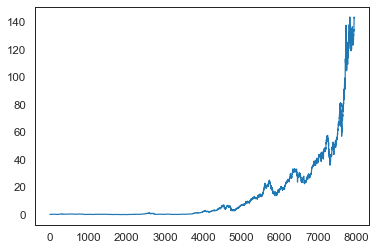

In [9]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [10]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

Training set shape ==(7942, 1)
[[0.00139232]
 [0.00156345]
 [0.001579  ]
 ...
 [0.99958175]
 [0.98592185]
 [0.994076  ]]


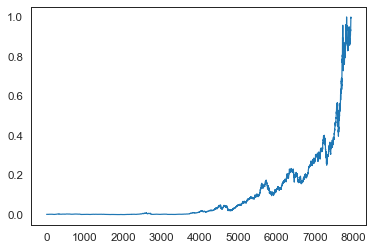

In [11]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print('Training set shape =={}'.format(df1.shape))
plt.plot(df1)
print(df1)

In [12]:
training_len=int(len(df1)*0.80)
test_len=len(df1)-training_len
train,test=df1[0:training_len,:],df1[training_len:len(df1),:1]
print("length of training data and test data :",training_len,test_len)
print("The training data is", train)
print("The testing data is ",test)

length of training data and test data : 6353 1589
The training data is [[0.00139232]
 [0.00156345]
 [0.001579  ]
 ...
 [0.21504013]
 [0.21855967]
 [0.22047624]]
The testing data is  [[0.22352534]
 [0.22265417]
 [0.22068533]
 ...
 [0.99958175]
 [0.98592185]
 [0.994076  ]]


In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [14]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [15]:
print(X_train.shape), print(Y_train.shape)

(6322, 30)
(6322,)


(None, None)

In [16]:
print(X_test.shape), print(Y_test.shape)

(1558, 30)
(1558,)


(None, None)

In [17]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [18]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=65, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Epoch 1/100
98/98 [==============================] - 2s 16ms/step - loss: 1.9112e-04 - val_loss: 0.0346
Epoch 2/100
98/98 [==============================] - 1s 12ms/step - loss: 5.4905e-04 - val_loss: 0.0139
Epoch 3/100
98/98 [==============================] - 1s 11ms/step - loss: 3.0585e-04 - val_loss: 0.0076
Epoch 4/100
98/98 [==============================] - 1s 11ms/step - loss: 2.2701e-04 - val_loss: 0.0063
Epoch 5/100
98/98 [==============================] - 1s 10ms/step - loss: 1.9613e-04 - val_loss: 0.0022
Epoch 6/100
98/98 [==============================] - 1s 11ms/step - loss: 1.5406e-04 - val_loss: 0.0012
Epoch 7/100
98/98 [==============================] - 1s 11ms/step - loss: 1.0780e-04 - val_loss: 6.3443e-04
Epoch 8/100
98/98 [==============================] - 1s 10ms/step - loss: 1.0022e-04 - val_loss: 7.3647e-04
Epoch 9/100
98/98 [==============================] - 1s 10ms/step - loss: 9.1514e-05 - val_loss: 3.4658e-04
Epoch 10/100
98/98 [==============================] 

In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 1.10561447967321
Train Root Mean Squared Error: 1.1657257983463107
Test Mean Absolute Error: 2.684754724276463
Test Root Mean Squared Error: 5.23040149305558


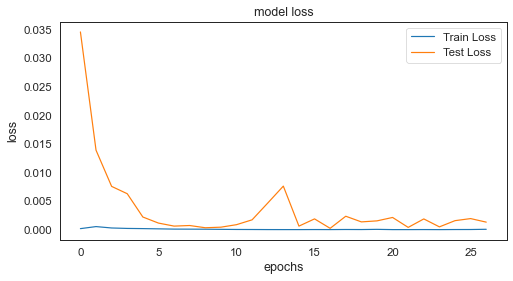

In [20]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [21]:
len(df1)

7942

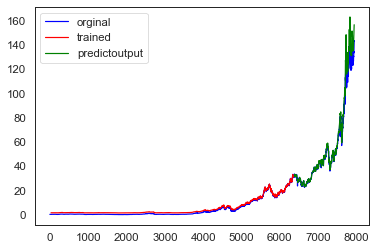

In [22]:
#plotting the trained graph with original one
##shift train predictions for plotting
lock_back=30
tpp=np.empty_like(df1)
tpp[:,:]=np.nan
tpp[lock_back:len(train_predict)+lock_back, :]=train_predict

#shift test prediction for plotting
tspp=np.empty_like(df1)
tspp[:,:]=np.nan
tspp[len(train_predict)+(lock_back*2)+1:len(df1)-1, :]=test_predict

#plotting the baseline and predcitions
plt.plot(scaler.inverse_transform(df1), color='blue', label='orginal')
plt.plot(tpp, color='red', label='trained')
plt.plot(tspp, color='green', label='predictoutput')
plt.legend(loc='best')


plt.show()

In [23]:
len(test)

1589

In [24]:
x_input=test[1489:].reshape(1,-1)
x_input.shape


(1, 100)

In [25]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [26]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[1.1229697]
101
1 day input [0.89964105 0.90688925 0.89134749 0.86172773 0.86995158 0.86813953
 0.85357353 0.86165802 0.8941353  0.86904554 0.84771929 0.84235289
 0.84200441 0.8287626  0.84730114 0.85322509 0.83831065 0.84534973
 0.87524827 0.86374885 0.85559465 0.83482597 0.8378228  0.8587309
 0.85517651 0.83231699 0.83796216 0.84702236 0.83628953 0.84702236
 0.86103081 0.86249437 0.88082378 0.87615432 0.89789871 0.90382271
 0.9227794  0.92222183 0.93964525 0.9318396  0.93518486 0.92967901
 0.94020282 0.92166428 0.92640339 0.92027043 0.93887862 0.94013306
 0.93525452 0.95030838 0.91762203 0.91943403 0.91351013 0.89964105
 0.89051119 0.91114057 0.90110467 0.85991568 0.85921876 0.86744261
 0.87908144 0.88305398 0.88124193 0.85754612 0.8719727  0.89002334
 0.8774088  0.89002334 0.88402968 0.88040563 0.87434227 0.87092729
 0.86535178 0.86813953 0.86388822 0.87852387 0.8815207  0.88577202
 0.88444783 0.88103285 0.89002334 0.90479842 0.9077952  0.90382271
 0.91016486 0.9073074  0.92006135 0

7 day output [[1.9533575]]
8 day input [0.86165802 0.8941353  0.86904554 0.84771929 0.84235289 0.84200441
 0.8287626  0.84730114 0.85322509 0.83831065 0.84534973 0.87524827
 0.86374885 0.85559465 0.83482597 0.8378228  0.8587309  0.85517651
 0.83231699 0.83796216 0.84702236 0.83628953 0.84702236 0.86103081
 0.86249437 0.88082378 0.87615432 0.89789871 0.90382271 0.9227794
 0.92222183 0.93964525 0.9318396  0.93518486 0.92967901 0.94020282
 0.92166428 0.92640339 0.92027043 0.93887862 0.94013306 0.93525452
 0.95030838 0.91762203 0.91943403 0.91351013 0.89964105 0.89051119
 0.91114057 0.90110467 0.85991568 0.85921876 0.86744261 0.87908144
 0.88305398 0.88124193 0.85754612 0.8719727  0.89002334 0.8774088
 0.89002334 0.88402968 0.88040563 0.87434227 0.87092729 0.86535178
 0.86813953 0.86388822 0.87852387 0.8815207  0.88577202 0.88444783
 0.88103285 0.89002334 0.90479842 0.9077952  0.90382271 0.91016486
 0.9073074  0.92006135 0.93149111 0.93623023 0.92933062 0.92898213
 0.93866955 0.94821755 0.

17 day output [[4.4319735]]
18 day input [0.84534973 0.87524827 0.86374885 0.85559465 0.83482597 0.8378228
 0.8587309  0.85517651 0.83231699 0.83796216 0.84702236 0.83628953
 0.84702236 0.86103081 0.86249437 0.88082378 0.87615432 0.89789871
 0.90382271 0.9227794  0.92222183 0.93964525 0.9318396  0.93518486
 0.92967901 0.94020282 0.92166428 0.92640339 0.92027043 0.93887862
 0.94013306 0.93525452 0.95030838 0.91762203 0.91943403 0.91351013
 0.89964105 0.89051119 0.91114057 0.90110467 0.85991568 0.85921876
 0.86744261 0.87908144 0.88305398 0.88124193 0.85754612 0.8719727
 0.89002334 0.8774088  0.89002334 0.88402968 0.88040563 0.87434227
 0.87092729 0.86535178 0.86813953 0.86388822 0.87852387 0.8815207
 0.88577202 0.88444783 0.88103285 0.89002334 0.90479842 0.9077952
 0.90382271 0.91016486 0.9073074  0.92006135 0.93149111 0.93623023
 0.92933062 0.92898213 0.93866955 0.94821755 0.95121443 0.96027452
 0.97539814 0.99958175 0.98592185 0.994076   1.12296975 1.17079628
 1.24074161 1.33191776 1.

27 day output [[4.7636127]]
28 day input [0.84702236 0.83628953 0.84702236 0.86103081 0.86249437 0.88082378
 0.87615432 0.89789871 0.90382271 0.9227794  0.92222183 0.93964525
 0.9318396  0.93518486 0.92967901 0.94020282 0.92166428 0.92640339
 0.92027043 0.93887862 0.94013306 0.93525452 0.95030838 0.91762203
 0.91943403 0.91351013 0.89964105 0.89051119 0.91114057 0.90110467
 0.85991568 0.85921876 0.86744261 0.87908144 0.88305398 0.88124193
 0.85754612 0.8719727  0.89002334 0.8774088  0.89002334 0.88402968
 0.88040563 0.87434227 0.87092729 0.86535178 0.86813953 0.86388822
 0.87852387 0.8815207  0.88577202 0.88444783 0.88103285 0.89002334
 0.90479842 0.9077952  0.90382271 0.91016486 0.9073074  0.92006135
 0.93149111 0.93623023 0.92933062 0.92898213 0.93866955 0.94821755
 0.95121443 0.96027452 0.97539814 0.99958175 0.98592185 0.994076
 1.12296975 1.17079628 1.24074161 1.33191776 1.44581747 1.58508348
 1.75309539 1.95335746 2.18837762 2.45788097 2.75656939 3.0724225
 3.38728595 3.68084145 3

In [27]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [28]:
df3=df1.tolist()
df3.extend(lst_output)
len(df1)

7942

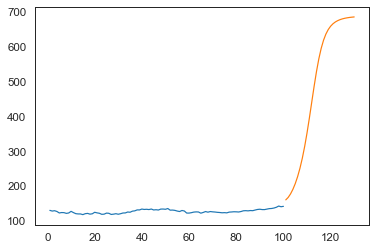

In [29]:
plt.plot(day_new,scaler.inverse_transform(df1[7842:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [30]:

result = []
  
for t in lst_output:
    for x in t:
        result.append(x)
len(result)

30

In [31]:
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(df1[7912:], result[0:])))

Root Mean Squared Error: 2.8358408859269977
